<a href="https://colab.research.google.com/github/shimjaeman/PyTorch-Tutorials/blob/main/05_(Pytorch)_Convolutional_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Network


1. CNN 개념과 구조

   * CNN : Convolutional Neural Networks의 약자로 딥러닝에서 주로 이미지나 영상 데이터를 처리할 때 쓰이며 이름에서 알수있다시피 Convolution이라는 전처리 작업이 들어가는 Neural Network 모델이다. 

   * 일반 DNN은 기본적으로 1차원 형태의 데이터를 사용합니다. 때문에 이미지가 입력값이 되는 경우, 이것을 flatten시켜서 한줄 데이터로 만들어야 하는데 이 과정에서 이미지의 공간적/지역적 정보(spatial/topological information)가 손실되게 됩니다. 또한 추상화과정 없이 바로 연산과정으로 넘어가 버리기 때문에 학습시간과 능률의 효율성이 저하됩니다.

   * 이미지를 구분할때 중요한 pixel이 있고, 필요없는 pixel이 존재할수 있기 때문에 인접한 pixel의 중요도를 참고하였다. 

  * CNN은 이미지를 날것(raw input) 그대로 받음으로써 공간적/지역적 정보를 유지한 채 특성(feature)들의 계층을 빌드업합니다. 

  * CNN의 중요 포인트는 이미지 전체보다는 부분을 보는 것, 그리고 이미지의 한 픽셀과 주변 픽셀들의 연관성을 살리는 것입니다.

2. Convolution

  * 하나의 합성곱 계층에는 입력되는 이미지의 채널 개수만큼 필터가 존재

  * 각 채널에 할당된 필터를 적용함으로써 합성곱 계층의 출력 이미지가 생성

  * 특정 패턴이 있는지 박스로 훓으며 마킹

  * 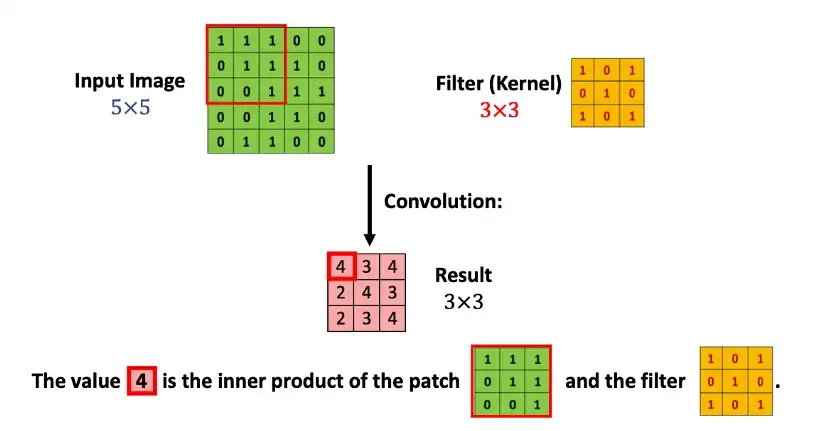


2-1. Stride

  * 이미지에 대해 필터를 적용할 때의 필터의 이동량을 의미

  * 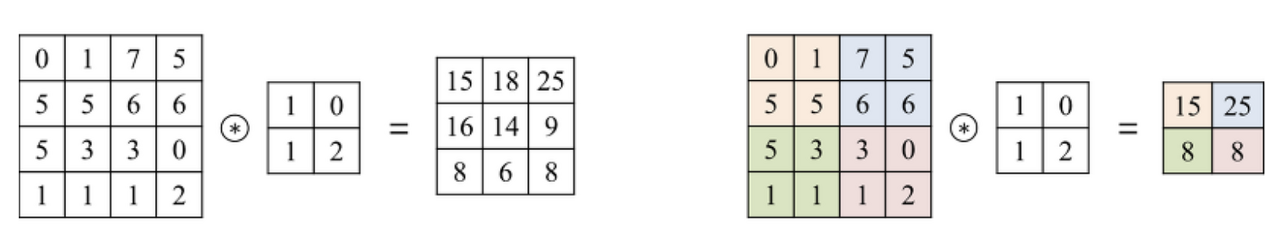


  - (왼쪽) stride = 1인 경우, (오른쪽) stride = 2인 경우

2.2. Zero Padding
  
   - Convolution 결과값의 크기가 손실되는 부분이 발생하여 0로 구성된 테두리를 이미지 가장자리에 감싸 손실 방지

   - 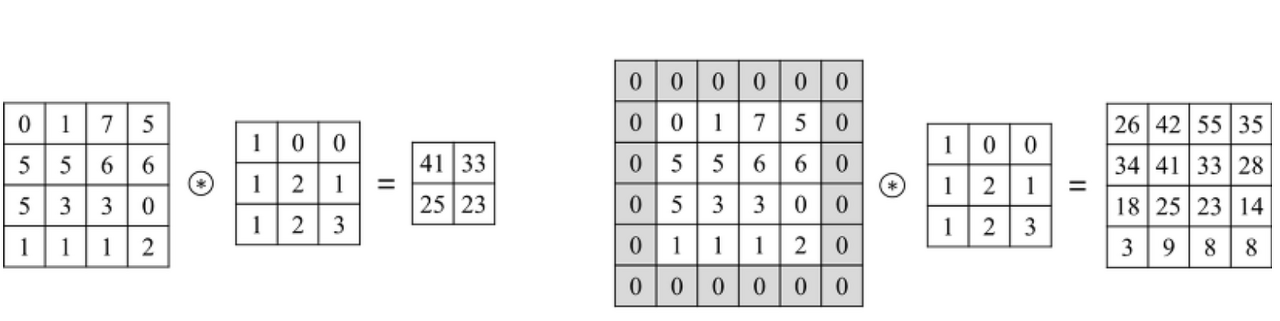

3. Pooling Layer

  -  Pooling은 각 결과값(feature map)의 dimentionality를 축소해 주는 것을 목적

  - correlation이 낮은 부분을 삭제하여 각 결과값을 크기(dimension)을 줄이는 과정

  - 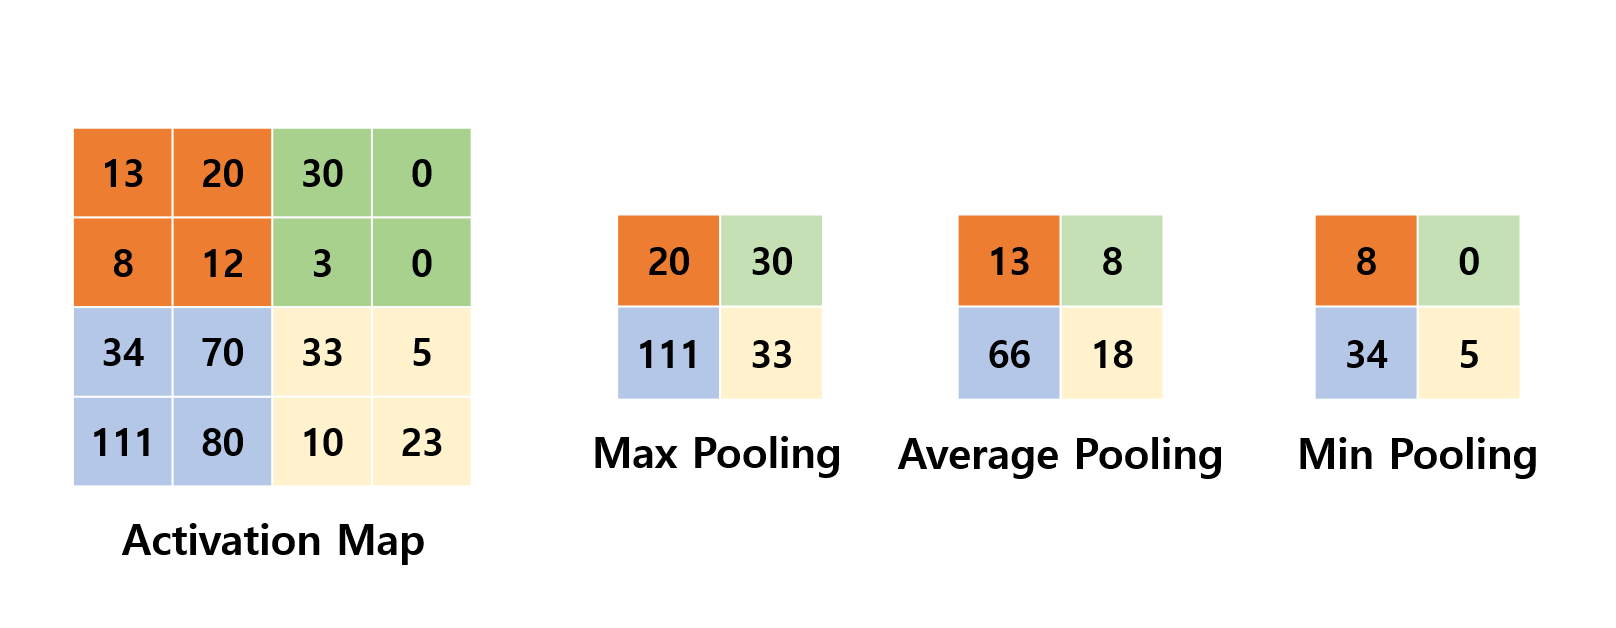

4. Flatten

 - 2차원/3차원의 행렬 구조를 1차원의 Vector로 변환하는 과정 

 - 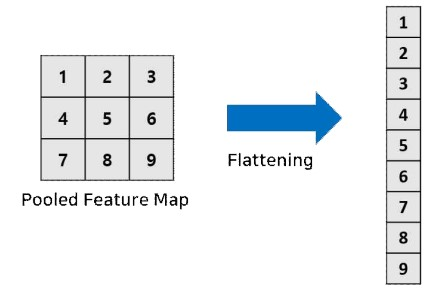

5. Fully-connected 계층

  - Flatten후에는 물체와 유사한 형태들의 Feature map들이 선별되어 Classification 하는 과정
  
  - 이전 계층의 모든 노드가 다음 계층의 모든 노드에 연결된 계층

  - 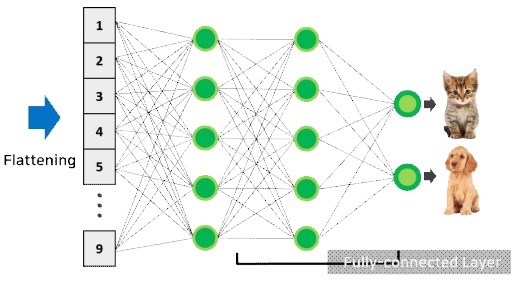

6. CNN의 전체적인 네트워크 구조

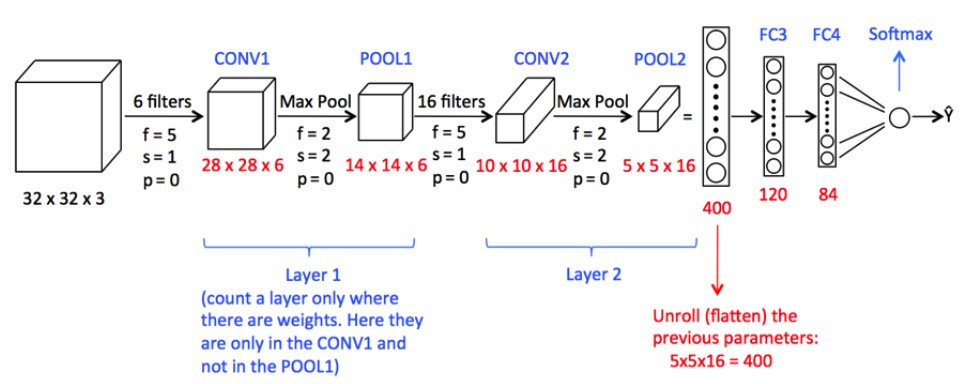

## Common parts

In [149]:
# 기본 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn 라이브러리
from sklearn.metrics import accuracy_score

# Pytorch 라이브러리
import torch
import torchvision
import torch.nn as nn # SGD, Adam 등과 같은 optimizer
import torch.optim as optim # 모든 neural network 모듈
import torch.nn.functional as F # Parameterless functions
from torch.utils.data import DataLoader # 미니배치를 생성하여 쉽게 데이터 셋 처리
import torchvision.datasets as datasets 
import torchvision.transforms as transforms # augumetation을 위해 데이터 세트에서 수행할 수 있는 변환
from torchsummary import summary
from tqdm import tqdm  # progress bar (진행상황 확인)

In [ ]:
# 파이썬 코드를 재실행해도 같은 결과가 나오도록 랜덤 시드(random seed) 설정
torch.manual_seed(1)

In [153]:
# Check accuracy on training & test 
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval() # eval mode에서 사용할 것이라고 모든 레이어에 선언하는 것

    # torch.no_grad() : 검증단계에서는 backprop을 하지 않을 것이기 때문에 
    # no_grad()로 감싸주고 이는 이 블럭 안에서는 그래디언트 트래킹을 안해도 된다 라고 선언 
    # ===> 메모리& 시간 감소
    with torch.no_grad():
        for x, y in loader:

            # Move data to device
            x = x.to(device=device)
            y = y.to(device=device)

            # Forward pass
            scores = model(x)
            predictions = scores.argmax(dim=1)

            # Check how many we got correct
            num_correct += (predictions == y).sum()

            # Keep track of number of samples
            num_samples += predictions.size(0)

    model.train() # eval => train 
    return num_correct / num_samples

In [ ]:
# Set device (Cuda / cpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## LeNet

> LeNet

* Convolution과 Subsampling을 반복적으로 거치면서, 마지막에 Fully-connected Mullti-layered Neural Network로 Classification을 수행

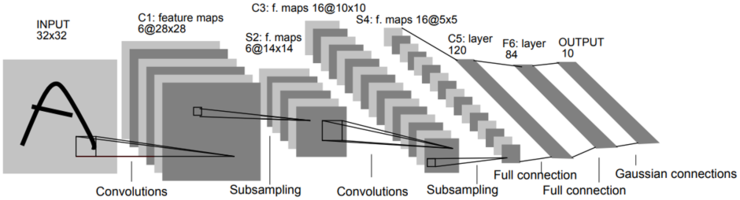

In [74]:
# Load Data
train_dataset = datasets.MNIST (root='dataset/', train=True, transform = transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST (root='dataset/', train=False, transform = transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size = 32)
test_loader = DataLoader(dataset=train_dataset, shuffle=False, batch_size = 32)

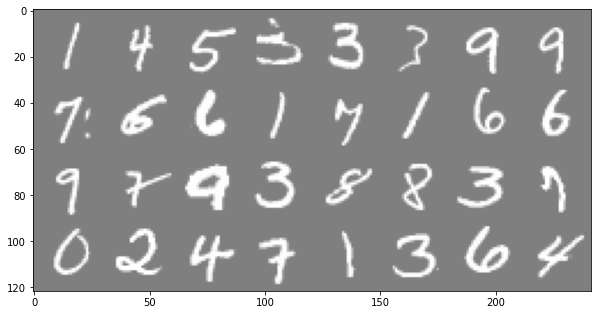

torch.Size([32, 1, 28, 28])


In [75]:
# 배치 및 이미지 크기 확인
def imshow(img):
    img = .5*img + .5
    plt.figure(figsize=(10,100))
    plt.imshow(img.permute(1,2,0).numpy())
    plt.show()

images, labels = next(iter(train_loader))
imshow(torchvision.utils.make_grid(images,nrow=8))
print(images.size()) 

In [114]:
### MNIST dataset 
# input_size: the size of the input, in this case 784 (28x28)
# num_classes: the number of classes we want to predict, in this case 10 (0-9)
# Simple CNN
class CNN(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=1, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=1, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        return x

In [115]:
# model creating
model = CNN().to(device)
model.parameters
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 30, 30]             128
         MaxPool2d-2           [-1, 64, 15, 15]               0
            Conv2d-3           [-1, 32, 17, 17]           2,080
         MaxPool2d-4             [-1, 32, 8, 8]               0
            Linear-5                   [-1, 10]          20,490
Total params: 22,698
Trainable params: 22,698
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.64
Params size (MB): 0.09
Estimated Total Size (MB): 0.73
----------------------------------------------------------------


In [116]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

In [117]:
# Train Network
num_epochs = 10
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # Forward
        scores = model(data)
        loss = criterion(scores, targets)

        # Backward
        optimizer.zero_grad()
        loss.backward()

        # Gradient descent or adam step
        optimizer.step()

100%|██████████| 1875/1875 [00:10<00:00, 180.43it/s]


In [118]:
# Check accuracy on training & test
print(f"Accuracy on training set : {check_accuracy(train_loader, model)*100:.2f}")
print(f"Accuracy on test set : {check_accuracy(test_loader, model)*100:.2f}")

Accuracy on training set : 90.04
Accuracy on test set : 90.04


## AlexNet

> AlexNet

* 전체적으로 2개의 GPU를 기반으로 한 병렬 구조

* 5개의 Convolution layers와 3개의 Fully-connected Layers로 구성

* 활성함수 : 중간중간에 Relu와 마지막에 다중분류를 위해 Softmax함수를 사용

* Overlapping : Pooling은 일반적으로 필터를 겹치지 않게 Stride를 적절히 조정하지만, AlexNet에서는 Stride를 좁혀 Overlapping 하는 구조

* LRN : 활성화 함수를 적용하기 전에 Normalization을 적용하여 함수의 결과값에서 더 좋은 일반화 결과를 도출
  - 특정 사물에 집중하면 그 부분만 집중하여 보이게 되는 현상 이용

* Dropout : 6, 7층(Fully-Connected)에서 50% 확률의 Dropout을 적용하여 Overfitting 낮춤

* Data Augmentation : 동일한 이미지들을 조금씩 변형시켜가며 학습하면 Overfitting을 방지하는 데 도움






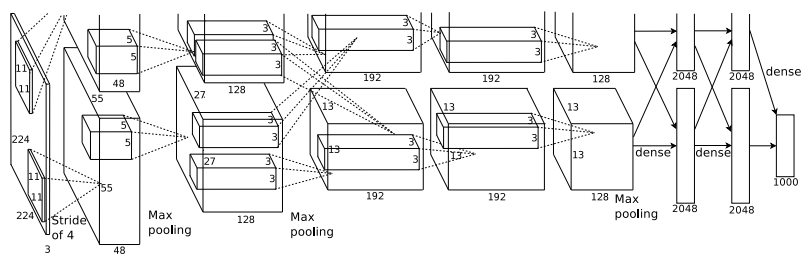

In [168]:
# Load Data
train_dataset = datasets.CIFAR10 (root='/data', train=True, transform = transforms.ToTensor(), download=True)
test_dataset = datasets.CIFAR10 (root='/data', train=False, transform = transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size = 100)
test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size = 100)

Files already downloaded and verified
Files already downloaded and verified


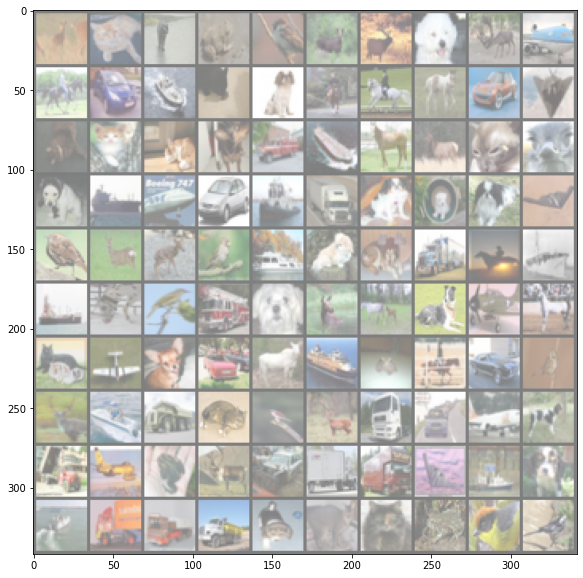

torch.Size([100, 3, 32, 32])


In [171]:
# 배치 및 이미지 크기 확인
def imshow(img):
    img = .5*img + .5
    plt.figure(figsize=(10,10))
    plt.imshow(img.permute(1,2,0).numpy())
    plt.show()

images, labels = next(iter(train_loader))
imshow(torchvision.utils.make_grid(images,nrow=10))
print(images.size()) 

In [172]:
# Conv→ReLU→MaxPool→ Conv→ReLU→MaxPool→Conv→ReLU→ Conv→ReLU→Conv→ReLU→MaxPool→FC1→ReLU→FC2→ReLU→FC3

class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
                        nn.Conv2d(3, 64, 3, 2, 1), nn.ReLU(), # in_channels, out_channels, kernel_size, stride, padding
                        nn.MaxPool2d(2, 2),
                        nn.Conv2d(64, 192, 3, padding=1), nn.ReLU(),
                        nn.MaxPool2d(2, 2),
                        nn.Conv2d(192, 384, 3, padding=1), nn.ReLU(),
                        nn.Conv2d(384, 256, 3, padding=1), nn.ReLU(),
                        nn.Conv2d(256, 256, 1), 
                        nn.BatchNorm2d(256), nn.ReLU(),
                        nn.MaxPool2d(2, 2)        
                        )
        
        self.classifier = nn.Sequential(
                        nn.Dropout(0.5),
                        nn.Linear(256*2*2, 1024), nn.ReLU(),
                        nn.Dropout(0.5),
                        nn.Linear(1024, 512), nn.ReLU(),
                        nn.Linear(512, 10)
                        )    
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)    
        return x

In [173]:
# model creating
alexnet = AlexNet().to(device) # 모델 선언
summary(alexnet, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           1,792
              ReLU-2           [-1, 64, 16, 16]               0
         MaxPool2d-3             [-1, 64, 8, 8]               0
            Conv2d-4            [-1, 192, 8, 8]         110,784
              ReLU-5            [-1, 192, 8, 8]               0
         MaxPool2d-6            [-1, 192, 4, 4]               0
            Conv2d-7            [-1, 384, 4, 4]         663,936
              ReLU-8            [-1, 384, 4, 4]               0
            Conv2d-9            [-1, 256, 4, 4]         884,992
             ReLU-10            [-1, 256, 4, 4]               0
           Conv2d-11            [-1, 256, 4, 4]          65,792
      BatchNorm2d-12            [-1, 256, 4, 4]             512
             ReLU-13            [-1, 256, 4, 4]               0
        MaxPool2d-14            [-1, 25

In [175]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet.parameters(), lr=0.0001)

In [176]:
# Train Network
num_epochs = 10
total_loss = []
for epoch in range(num_epochs):
    running_train_loss = 0.0
    for data, targets in train_loader:
        data = data.to(device)
        targets = targets.to(device)
        scores = alexnet(data)
        loss = criterion(scores, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    total_loss.append(running_train_loss / len(train_loader))

    # evaluation 
    num_correct = 0.0
    num_samples = 0.0
    with torch.no_grad(): # requires_grad 비활성화
        model.eval()
        for data, targets in train_loader:
            data = data.to(device)
            targets = targets.to(device)
            outputs = alexnet(data)
            predictions = outputs.argmax(dim=1)
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)
    model.train()
    # epoch, loss, acc print
    acc = num_correct / num_samples
    print(f"Epoch : {epoch}, Loss : {total_loss[-1]:.5f}, acc : {acc:.2f}")

Epoch : 0, Loss : 1.66180, acc : 0.50
Epoch : 1, Loss : 1.24520, acc : 0.60
Epoch : 2, Loss : 1.08118, acc : 0.64
Epoch : 3, Loss : 0.95807, acc : 0.69
Epoch : 4, Loss : 0.86211, acc : 0.73
Epoch : 5, Loss : 0.77695, acc : 0.75
Epoch : 6, Loss : 0.69901, acc : 0.78
Epoch : 7, Loss : 0.62241, acc : 0.81
Epoch : 8, Loss : 0.54899, acc : 0.84
Epoch : 9, Loss : 0.47847, acc : 0.87


In [166]:
# Check accuracy on training & test
print(f"Accuracy on training set : {check_accuracy(train_loader, alexnet)*100:.2f}")
print(f"Accuracy on test set : {check_accuracy(test_loader, alexnet)*100:.2f}")

Accuracy on training set : 83.91
Accuracy on test set : 68.71


## torchvison.models

* 파이토치의 경우 torchvision.models as models을 이용해 다양한 신경망을 사용할수 있다.

* 그러나 각 모델 별로 클래스 개수가 특정 데이터에 맞춰 설정되었기 때문에, 필요한 데이터의 클래스 수로 변경하여야 한다. 

https://tutorials.pytorch.kr/beginner/finetuning_torchvision_models_tutorial.html